<a href="https://colab.research.google.com/github/tsangrebecca/BloomTech/blob/main/Sprint7/Module4/DS_234_guided_project_notes_PDP_ShapleyPlots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### BloomTech Data Science


---

# Model Interpretation

- Visualize and interpret **partial dependence plots**
- Explain individual predictions with **shapley value plots**


In [ ]:
!pip install category_encoders
# !pip install pdpbox  -- old syntax
!pip install PDPbox
!pip install shap

In [5]:
import pandas as pd
from sklearn.linear_model import Ridge,LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from pdpbox.pdp import PDPIsolate, PDPInteract
from pdpbox.info_plots import TargetPlot, InteractTargetPlot

import shap
import warnings

In [ ]:
# from pdpbox.pdp import PDPIsolate, PDPInteract --- already did it above

# have to add this line as well
# from pdpbox.info_plots import TargetPlot, InteractTargetPlot --- already did it above

In [ ]:
# from pdpbox import pdp, get_dataset, info_plots

In [6]:
pdp_isolate = PDPIsolate
pdp_plot = TargetPlot
pdp_interact = PDPInteract
pdp_interact_plot = InteractTargetPlot

In [7]:
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

In [8]:
pd.set_option('display.max_columns', 500)

# I. Wrangle Data

In [45]:
DATA_PATH = 'https://raw.githubusercontent.com/bloominstituteoftechnology/DS-Unit-2-Applied-Modeling/master/data/'


In [46]:
df = pd.read_csv(DATA_PATH+'lending-club/lending-club-subset.csv')

In [47]:
def wrangle(filepath):

  # Set issue date to index
  df = pd.read_csv(filepath, parse_dates=['issue_d'], index_col='issue_d').sort_index()

  # subset data to 36-month loans
  mask = df['term'].str.strip() == '36 months'  # str.strip with delete any white spaces in that cell value, if we have any extra space
  df = df[mask]
  # it'll become a constant column so we need to drop it
  df.drop(columns='term', inplace=True)

  # Turn `'int_rate'` col into float, we don't need the % sign also there's a leading white space
  df['int_rate'] = df['int_rate'].str.strip(' %').astype(float) # or integer. re-assign this to the int_rate column

  # Consolidate to reduce cardinality and OHE loan purpose (`'title'`)
  # group them in only 4 categories, (or even can choose top 5 or 10 even and put the rest in a category called Other)
  keywords = ['business', 'consolidation|credit', 'home', 'car|vacation|medical|moving']
  # these 4 new columns are binary columns from the one hot encoding
  # pass through each value that has been put inside these titles into every row and see if any of those values contain these keywords
  # write a for loop to create 4 new columns having the names that are in the keywords so that's why we're looping through the list of keywords
    # the moment we see a value which has a the word 'business' in it, we're going to populate that particular business column as 1 and everywhere else 0
    # the for loop allows parsing through each of these keyword and create new columns for each
  for col in keywords:          # parsing through the keyword list
    df[col] = (df['title']     # create new column for each; use RegEx (regular expression) to create one hot encoding
               .fillna('')      # account for any null values, just keep it empty for now with ''
               .str.lower()     # bring all values to lower case
               .str.contains(col, regex=True)   # tests if a regular pattern (or a RegEx) contains a string or a series or an index, and returns a Boolean if it finds that particular pattern
               .astype(int))                     # regex allows us to do multiple pattern searches
                                                # A regex is a special sequence of characters that helps you match strings or sets of strings using a specialized syntax
                                                # the moment we found a pattern as True we're going to convert it to an integer type e.g. 1

  # we have 150 columns, just limit to 8, the new binary columns and 4 extra columns
  columns_to_keep = keywords + ['annual_inc','funded_amnt','int_rate','fico_range_high']

  df = df[columns_to_keep]

  # Rename columns
  # df.rename(columns={'annual_inc': 'annual_income',
  #                   'business': 'purpose_business',
  #                   'car|vacation|medical|moving': 'purpose_major_purchase',
  #                   'consolidation|credit': 'purpose_consolidation',
  #                   'fico_range_high': 'credit_score',
  #                   'funded_amnt': 'loan_amount',
  #                   'home': 'purpose_home_purchase',
  #                   'int_rate': 'interest_rate'}, inplace=True)
  return df

df = wrangle(DATA_PATH+'lending-club/lending-club-subset.csv')

In [ ]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,109889419.0,NaN,20000.0,20000.0,20000.0,36 months,9.44%,640.10,B,B1,IT Support,10+ years,MORTGAGE,99500.0,Source Verified,May-2017,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,296xx,SC,17.19,0.0,Feb-2005,690.0,694.0,0.0,NaN,NaN,15.0,0.0,12835.0,41%,28.0,w,0.0,0.0,21657.670000,21657.67,20000.0,1657.67,0.0,0.0,0.0,Jun-2018,1002.69,NaN,Jul-2018,744.0,740.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,1185.0,159516.0,2.0,3.0,0.0,2.0,16.0,59354.0,70.0,2.0,2.0,4810.0,57.0,31300.0,2.0,0.0,1.0,4.0,10634.0,15465.0,45.4,0.0,0.0,147.0,115.0,3.0,3.0,4.0,3.0,NaN,7.0,NaN,0.0,4.0,4.0,7.0,9.0,8.0,11.0,16.0,4.0,15.0,0.0,0.0,0.0,2.0,100.0,28.6,0.0,0.0,206029.0,72189.0,28300.0,84078.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68579794.0,NaN,21600.0,21600.0,21600.0,36 months,9.80%,694.95,B,B3,Engineer Tech,10+ years,MORTGAGE,79000.0,Verified,Jan-2016,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,219xx,MD,18.94,1.0,Jun-1995,680.0,684.0,0.0,12.0,NaN,13.0,0.0,17498.0,88.4%,16.0,w,0.0,0.0,24983.207947,24983.21,21600.0,3383.21,0.0,0.0,0.0,Nov-2018,8.94,NaN,May-2019,709.0,705.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,291267.0,0.0,2.0,2.0,2.0,7.0,33987.0,88.0,0.0,0.0,4746.0,88.0,19800.0,0.0,0.0,0.0,2.0,22405.0,897.0,91.1,0.0,0.0,101.0,247.0,27.0,7.0,4.0,27.0,12.0,NaN,12.0,0.0,3.0,7.0,4.0,4.0,4.0,8.0,8.0,7.0,13.0,0.0,0.0,0.0,2.0,93.7,75.0,0.0,0.0,337728.0,51485.0,10100.0,38591.0,NaN,NaN,N

In [ ]:
df.shape

(128334, 150)

In [ ]:
df['title'].nunique()

7868

In [ ]:
df['title'].value_counts().head(20)
# we can simplify, e.g. debt consolidation, debt consolidation loan, Debt consolidation, Consolidation, some uppercase, some lower case

Debt consolidation           62685
Credit card refinancing      25616
Home improvement              7164
Other                         6170
Major purchase                2353
Debt Consolidation            1388
Medical expenses              1350
Car financing                 1162
Business                       949
Vacation                       761
Moving and relocation          689
debt consolidation             458
Home buying                    457
Consolidation                  450
Debt Consolidation Loan        326
Credit Card Consolidation      219
consolidation                  190
Personal Loan                  171
Consolidation Loan             161
Home Improvement               159
Name: title, dtype: int64

In [ ]:
df['int_rate'][0] # there's a leading space and a % sign that we need to remove

'  9.44%'

In [ ]:
df.head()

,business,consolidation|credit,home,car|vacation|medical|moving,annual_inc,funded_amnt,int_rate,fico_range_high
issue_d,,,,,,,,
2007-07-01,0,0,0,0,20000.0,3500.0,10.28,684.0
2007-07-01,0,0,0,0,95000.0,5000.0,7.43,774.0
2007-07-01,0,0,0,0,150000.0,5000.0,7.43,779.0
2007-07-01,0,0,0,0,200000.0,3000.0,10.28,679.0
2007-08-01,0,0,0,0,61800.0,4000.0,7.75,749.0


# II. Split Data

In [48]:
# Split our data in feature matrix and target vector
target = 'int_rate'
X = df.drop(columns=target)
y = df[target]


In [49]:
# Split data into training, validation, test sets, we only have 1 dataset so we need to split it ourselves
# Because this is datetime data, we'll do a cutoff
# sort_index is the key here! (in the wrangle function, so most recent one will be at the end) so we need to take tail as test data!

# Use numpy array slicing syntax, 80 training / 10 validation / 10 test
int(len(X) * .10) # we found out that 10% will be 10299
# use row index
X_train, y_train = X[:-20_000], y[:-20_000] # everything from the start: until the last 20,000 rows
X_val, y_val = X[-20_000:-10_000], y[-20_000:-10_000] # from the last 20,000 rows to the last 10,000 rows
X_test, y_test = X[-10_000:], y[-10_000:] # the last 10,000 rows till the end:


In [30]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82996 entries, 2007-07-01 to 2016-12-01
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   business                     82996 non-null  int64  
 1   consolidation|credit         82996 non-null  int64  
 2   home                         82996 non-null  int64  
 3   car|vacation|medical|moving  82996 non-null  int64  
 4   annual_inc                   82996 non-null  float64
 5   funded_amnt                  82996 non-null  float64
 6   fico_range_high              82996 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 5.1 MB


- all data is numerical - great
- no null values, no need imputation

# III. Establish Baseline

In [ ]:
# regression task so baseline is MEAN
print('Mean interest rate:', y_train.mean())

y_pred = [y_train.mean()] * len(y_train)
print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

# our goal is to build a model that beats the MAE of 2.8988

Mean interest rate: 11.559685527013349
Baseline MAE: 2.8988644656907225


# IV. Build Model

In [50]:
# not using any pipelines

model_lr = LinearRegression()
# model_r = Ridge()
model_rf = RandomForestRegressor(random_state=42, n_jobs=-1)
model_xgb = XGBRegressor(random_state=42, n_jobs=-1)

In [51]:
model_lr.fit(X_train, y_train)
# model_r.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

We don't need a pipeline today. No scaling or imputation needed.

# V. Check Metrics

In [ ]:
def check_metrics(model):
  print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
  print('Validation MAE:', mean_absolute_error(y_val, model.predict(X_val)))
  print('Validation R^2:', model.score(X_val, y_val))
  print()
  print()

models = [model_lr,
          # model_r,
          model_rf,
          model_xgb]

for m in models:
  check_metrics(m)

Training MAE: 2.3998605913358473
Validation MAE: 2.644777307069022
Validation R^2: 0.22254825417422563


Training MAE: 1.1495022990410637
Validation MAE: 2.7699335974071904
Validation R^2: 0.1408914858381678


Training MAE: 2.152504812594787
Validation MAE: 2.5679028082008357
Validation R^2: 0.253357898663519




In [ ]:
# R2 is most 0.25, meaning only 25% of the prediction of interest rate is captured by our model features, not a good model, might need to do more feature engineering

# VI. Communicate Results

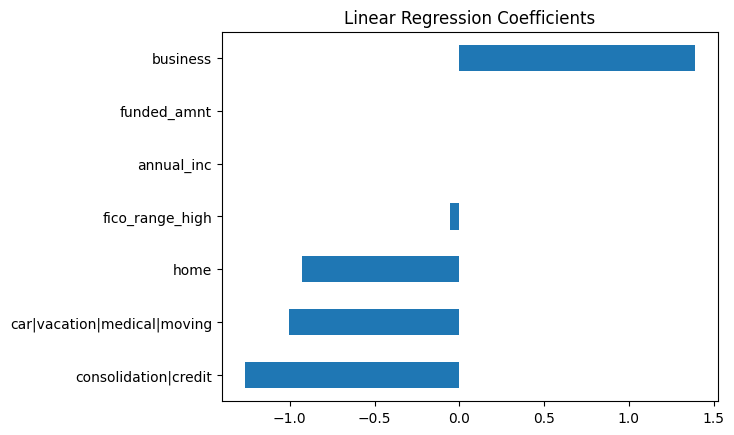

In [ ]:
coefficients = model_lr.coef_ # change in y for a unit change in X
coef = pd.DataFrame(data=coefficients, index=X_train.columns,columns=['coefficients'])
coef['coefficients'].sort_values().plot(kind='barh')
plt.title('Linear Regression Coefficients')
plt.show()
# y axis is features, X is lr coefficients

In [ ]:
model_lr.intercept_

51.10122488917061

In [ ]:
coef

,coefficients
business,1.392802
consolidation|credit,-1.266670
home,-0.926305
car|vacation|medical|moving,-1.005387
annual_inc,-0.000004
funded_amnt,0.000019
fico_range_high,-0.054677


### linear regression equation
interest_rate = model_lr.intercept_ + -0.000004*annual_inc + -0.054677*fico_range_high + 1.392802*business + -1.266670*consolidation|credit + -0.926305*home + -1.005387*car|vacation|medical|moving

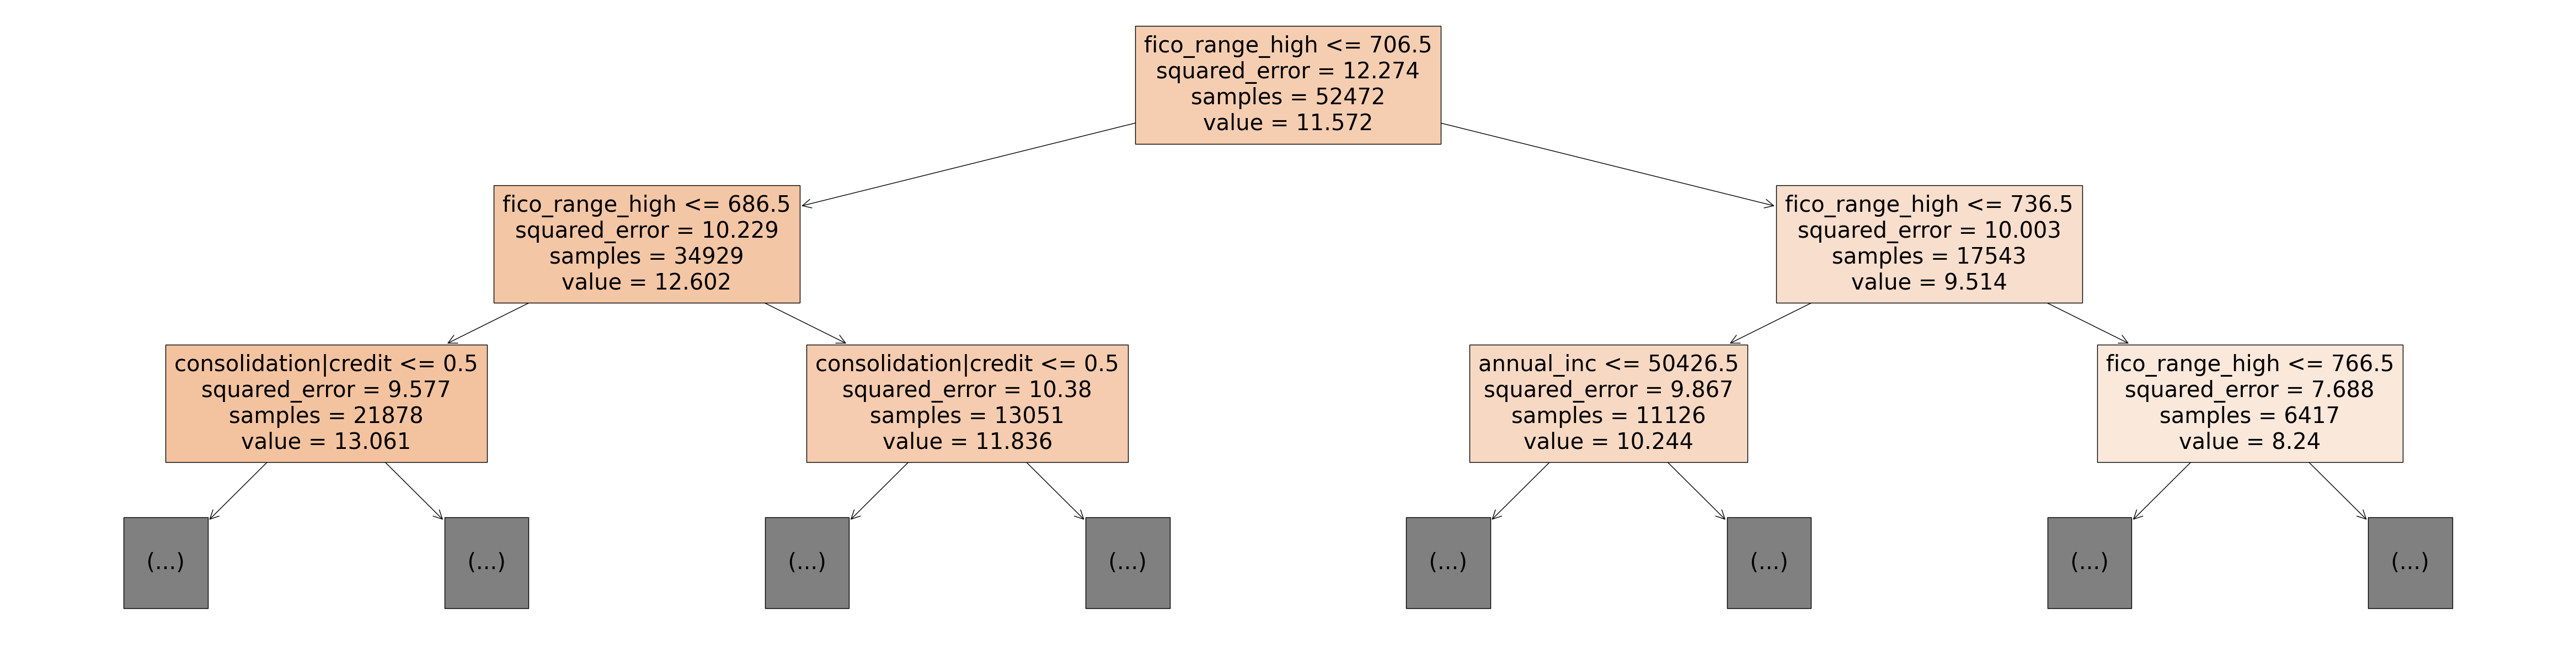

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(60,15))

plot_tree(
     model_rf.estimators_[0], # first tree
     max_depth=2,
     feature_names=X_train.columns,
     filled=True
);

In [ ]:
# fairly easy to understand, unlike neural networks also called black box models haha

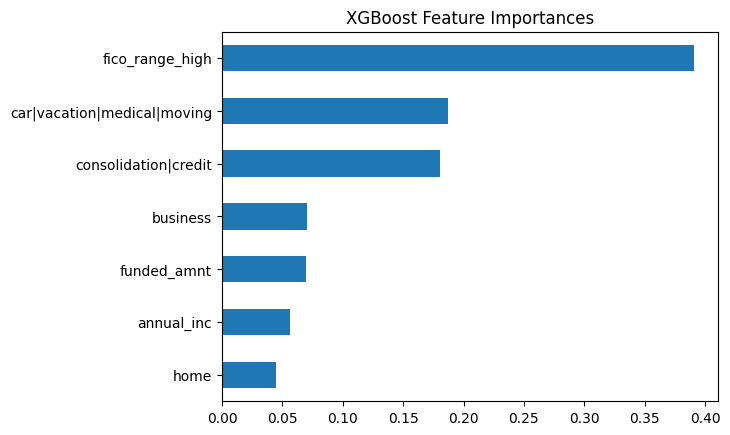

In [ ]:
# feature importance chart - downside is we cannot tell in which direction my feature is influencing the target
importances = model_xgb.feature_importances_ # use the feature_importances_ attribute for the xgb model
imp = pd.DataFrame(data=importances, index=X_train.columns, columns=['coefficients'])
imp['coefficients'].sort_values().plot(kind='barh')
plt.title('XGBoost Feature Importances')
plt.show()

In [ ]:
imp

,coefficients
business,0.070710
consolidation|credit,0.180832
home,0.044454
car|vacation|medical|moving,0.187213
annual_inc,0.055916
funded_amnt,0.069743
fico_range_high,0.391133


# Methods to better understand the relationship between feature and target

## Partial Dependence Plots

One Feature

- similar to coefficients in regression model but can capture features of more complex models
- shows how one feature explains the model on an average
- downside: assume NO correlation between each feature, which might not be true in some cases

In [ ]:
# !pip install pdpbox
# old syntax above

# new syntax here but it's installed above already so no need to re-do it
# !pip install PDPbox

In [33]:
from pdpbox.pdp import PDPIsolate, PDPInteract

# have to add this line as well
from pdpbox.info_plots import TargetPlot, InteractTargetPlot

In [34]:
# select one feature
sample_feature = 'annual_inc'

In [35]:
X_val.columns

Index(['business', 'consolidation|credit', 'home',
       'car|vacation|medical|moving', 'annual_inc', 'funded_amnt',
       'fico_range_high'],
      dtype='object')

In [36]:
# create an instance of PDP Isolate and save it as an object called isolate in our case
# AFTER a model has been fitted so don't use training set, use validation data
# isolate = pdp_isolate(

isolate = PDPIsolate(
    model = model_xgb,
    df = X_val,
    model_features = X_val.columns, # all the features
    feature = sample_feature,  # that ONE feature of interest, argument name is 'feature' not 'features'
    feature_name = sample_feature,
    n_classes=0  # we need to enter n_classes=0 for regression
 )

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

In [40]:
fig, axes = isolate.plot()
fig

In [ ]:
# pdp_plot(isolate, feature_name=sample_feature) -- OLD SYNTAX

- each dot represents 10 percentile

In [ ]:
pd.qcut(X['annual_inc'], q=10).value_counts()

(48000.0, 55000.0]       11317
(63000.0, 72000.0]       10683
(32000.0, 40000.0]       10622
(99900.0, 125000.0]      10608
(-0.001, 32000.0]        10514
(82500.0, 99900.0]       10262
(40000.0, 48000.0]       10009
(125000.0, 9300000.0]     9991
(55000.0, 63000.0]        9512
(72000.0, 82500.0]        9478
Name: annual_inc, dtype: int64

In [ ]:
# income percentile
# isolate.percentile_info -- OLD SYNTAX

In [ ]:
# interest rates corresponding to above percentiles
# isolate.pdp -- OLD SYNTAX

Two features

In [52]:
# select two features
sample_two_features = ['annual_inc', 'fico_range_high']  # it'll look like a grid

# use interact for 2 features, use isolate for 1 feature
# create an instance of PDP Interact.
interact = pdp_interact(
    model=model_xgb,
    df=X_val,
    model_features=X_val.columns,
    features=sample_two_features,
    feature_names=sample_two_features,
    n_classes=0
)

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# pdp_interact_plot(interact, plot_type='grid', feature_names=sample_two_features) -- OLD SYNTAX

In [53]:
fig, axes = interact.plot()
fig

####OLD GRAPH
- as you increase your annual income, the color is changing from yellow to green and the color basically indicates our interest rate
- seems like credit score has more effect on interest rate than annual income

## Shapley Plots
- shows influence of features of individual prediction
- just one observation, just one row

In [55]:
#select one sample/observation
sample_row = X_val.tail(1) # the very last row
sample_row

,business,consolidation|credit,home,car|vacation|medical|moving,annual_inc,funded_amnt,fico_range_high,x
issue_d,,,,,,,,
2017-08-01,0,1,0,0,38000.0,7000.0,739.0,7.0


## Shapley Force Plot
- may not work well in local notebooks
- may need to install ipywidgets
- shapley doesn't like pipelines
- need to transform dataset first if it's necessary for shapley to work
- Shapley value is a measure of how each of the features is contributing towards the prediction for THAT PARTICULAR observation
- TreeExplainer only works for tree-based models, if not, might have to use something called a kernal shap instead of a tree shap, and those take a lot of time to build, so use tree-based model

In [60]:
explainer.expected_value

array([11.55968571])

In [61]:
import shap
# create an explainer object
explainer = shap.TreeExplainer(model_xgb)          # only works for tree-based models
shap_values = explainer.shap_values(sample_row)

#initialization of java script
shap.initjs()



ValueError: ignored

In [ ]:
# build the force plot
shap.force_plot(
    base_value = explainer.expected_value,  # that's the mean
    shap_values=shap_values,
    features=sample_row,
    matplotlib=True
)
